# Summary table

| Method                | Lower outlier threshold   | Upper outlier threshold    | pct of outliers                    |
|-----------------------|---------------------------|----------------------------|------------------------------------|
| Z-score 3 std         | Heigth: 1.39; Weight 29.5 | Heigth: 1.98; Weight 116.9 | H: 7/10k = 0.07%; W: 2/10k = 0.02% |
| Box plot 1.5 IQR      | Heigth: 1.40; Weight 26.7 | Heigth: 1.97; Weight 119.8 | H: 8/10k=0.08%; W: 1/10k = 0.01%   |
| Box plot 3 IQR        | Heigth: 1.18; Weight -8.3 | Heigth: 2.19; Weight 154.7 | 0                                  |
| Cook's distance t=4/N | -                         | -                          | 365/10k = 3.65%                    |



# Imports

In [74]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

#increase font size of all elements
sns.set(font_scale=1.5)


# Load the data

In [75]:
import os
import requests

# Data can be found at https://www.kaggle.com/datasets/mustafaali96/weight-height and also at the following url
url = "https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv"

def download_data(url, force_download=False, **read_csv_kwargs):
    # Donwload data if it is not in disk
    data_path = os.path.join('data', os.path.basename(url.split('?')[0]))
    if not os.path.exists(data_path) or force_download:
        # ensure data dir is created
        os.makedirs('data', exist_ok=True)
        # request data from url
        response = requests.get(url, allow_redirects=True)
        # save file
        with open(data_path, "w") as f:
            # Note the content of the response is in binary form: 
            # it needs to be decoded.
            # The response object also contains info about the encoding format
            # which we use as argument for the decoding
            f.write(response.content.decode(response.apparent_encoding))
    print(f"File saved to {data_path}")

download_data(url)


File saved to data\weight-height.csv


In [76]:
# read csv file
data = pd.read_csv('data/weight-height.csv')
#Convert inches/pounds to m/kg
data.loc[:, 'Weight'] /= 2.205
data.loc[:, 'Height'] /= 39.37

# visualize the first 5 rows
data.head()


,Gender,Height,Weight
0,Male,1.875718,109.702296
1,Male,1.747064,73.610192
2,Male,1.882400,96.481114
3,Male,1.821970,99.792504
4,Male,1.775001,93.582676


# Plot histograms


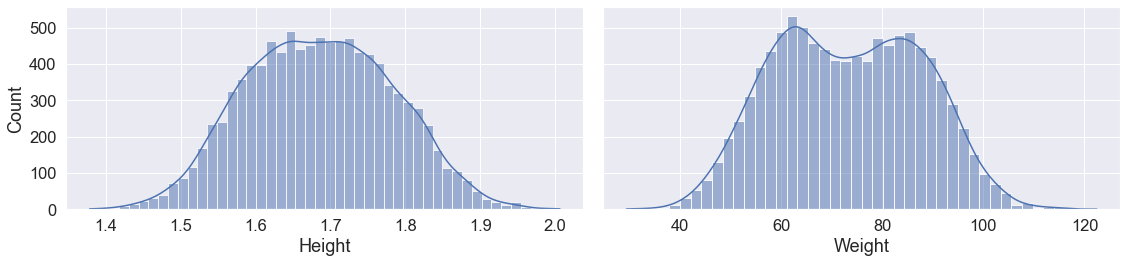

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,4))
sns.histplot(data=data, x='Height', kde=True, ax=ax1)
sns.histplot(data=data, x='Weight', kde=True, ax=ax2)
fig.tight_layout()

<AxesSubplot:xlabel='Weight', ylabel='Count'>

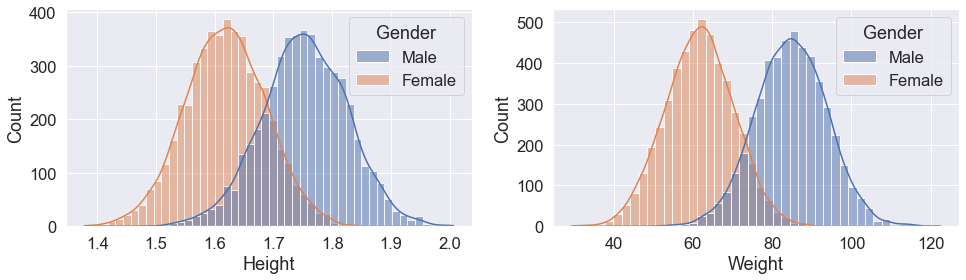

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
sns.histplot(data=data, x='Height', hue='Gender', kde=True, ax=ax1)
sns.histplot(data=data, x='Weight', hue='Gender', kde=True, ax=ax2)

# Print basic statistics wtih `describe`


In [79]:
display(data.describe())

,Height,Weight
count,10000.000000,10000.000000
mean,1.685739,73.215581
std,0.097727,14.561650
min,1.378286,29.342461
25%,1.613046,61.595488
50%,1.684482,73.112439
75%,1.757030,84.884138
max,2.006572,122.444308


# Z-score

In [80]:
from scipy.stats import zscore
# help(zscore)

## Outlier ratio

In [81]:
# Compute z-score
data_with_z = data.join(data[['Height', 'Weight']].apply(zscore), rsuffix='_z_score')

# compute outlier masks for Height and Weight
is_outlier_H = (data_with_z.Height_z_score.abs() > 3)
is_outlier_W = (data_with_z.Weight_z_score.abs() > 3)

# TODO complete to show the outlier count and ratio
# Display outlier count for height
outlier_count = is_outlier_H.sum()
outlier_ratio = is_outlier_H.mean()
print(
    f'Height outlier count: {outlier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
up = data.Height.mean() + 3* data.Height.std()
lo = data.Height.mean() - 3* data.Height.std()
print(f"Thresholds on height: {up:0.2f} (upper) and {lo:0.2f} (lower)")
# Display the outlier count for width
outlier_count = is_outlier_W.sum()
outlier_ratio = is_outlier_W.mean()
print(
    f'Weight outlier count: {outlier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
up = data.Weight.mean() + 3* data.Weight.std()
lo = data.Weight.mean() - 3* data.Weight.std()
print(f"Thresholds on weight: {up:0.2f} (upper) and {lo:0.2f} (lower)")

Height outlier count: 7/10000 (0.07000%)
Thresholds on height: 1.98 (upper) and 1.39 (lower)
Weight outlier count: 2/10000 (0.02000%)
Thresholds on weight: 116.90 (upper) and 29.53 (lower)


**Note**: z-score can also be applied by group:

In [82]:
data.join(data.groupby('Gender').apply(zscore), rsuffix='_z_score')

,Gender,Height,Weight,Height_z_score,Weight_z_score
0,Male,1.875718,109.702296,1.683739,2.774278
1,Male,1.747064,73.610192,-0.085377,-1.249301
2,Male,1.882400,96.481114,1.775629,1.300369
3,Male,1.821970,99.792504,0.944660,1.669526
4,Male,1.775001,93.582676,0.298787,0.977249
...,...,...,...,...,...
9995,Female,1.680789,62.030591,0.913897,0.048230
9996,Female,1.703509,77.491114,1.245684,1.840524
9997,Female,1.622250,58.265451,0.059057,-0.388252
9998,Female,1.753473,74.309506,1.975312,1.471690


# Box-plots + interquartile range


## Whiskers at 1.5 IQR

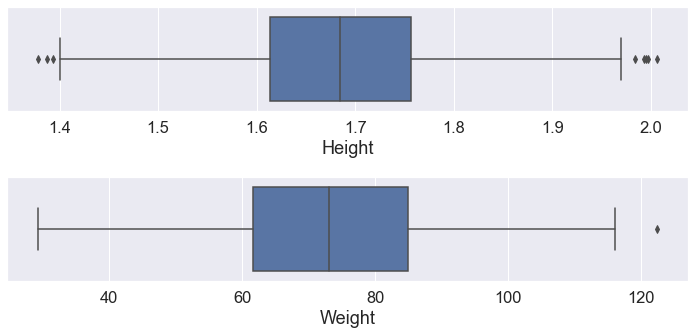

In [83]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
sns.boxplot(data=data, x='Height',orient='horiz', ax=ax1)
sns.boxplot(data=data, x='Weight',orient='horiz', ax=ax2)
fig.tight_layout()

## Whiskers at 3 IQR

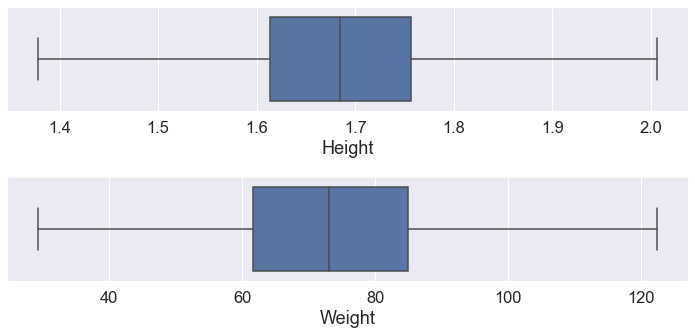

In [84]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
sns.boxplot(data=data, x='Height',orient='horiz', whis=3, ax=ax1)
sns.boxplot(data=data, x='Weight',orient='horiz', whis=3, ax=ax2)
fig.tight_layout()

## Outlier ratio

In [85]:
q1 = data.quantile(0.25, interpolation='nearest')
q3 = data.quantile(0.75, interpolation='nearest')
IQR = q3-q1
IQR

Height     0.143959
Weight    23.285521
dtype: float64

### 1.5 IQR

In [86]:
k = 1.5
lower, upper = q1-k*IQR, q3+k*IQR
"lower: ", lower, "upper: ", upper

('lower: ',
 Height     1.397114
 Weight    26.667679
 dtype: float64,
 'upper: ',
 Height      1.972952
 Weight    119.809765
 dtype: float64)

In [87]:
upper_outliers = data.Height > upper.loc['Height']
lower_outliers = data.Height < lower.loc['Height']
# TODO complete to retrieve outlier count and ratio
outilier_count = (upper_outliers | lower_outliers).sum()
outlier_ratio = (upper_outliers | lower_outliers).mean()
print(
    f'Height outlier count: {outilier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
print(f"Thresholds on height: {lower.Height:0.2f} (lower) "
      f"and {upper.Height:0.2f} (upper)")

Height outlier count: 8/10000 (0.08000%)
Thresholds on height: 1.40 (lower) and 1.97 (upper)


In [88]:
upper_outliers = data.Weight > upper.loc['Weight']
lower_outliers = data.Weight < lower.loc['Weight']
# TODO complete to retrieve outlier count and ratio
outilier_count = (upper_outliers | lower_outliers).sum()
outlier_ratio = (upper_outliers | lower_outliers).mean()
print(
    f'Weight outlier count: {outilier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
print(f"Thresholds on weight: {lower.Weight:0.2f} (lower) "
      f"and {upper.Weight:0.2f} (upper)")

Weight outlier count: 1/10000 (0.01000%)
Thresholds on weight: 26.67 (lower) and 119.81 (upper)


### 3 IQR

In [89]:
k = 3
lower, upper = q1-k*IQR, q3+k*IQR
"lower: ", lower, "upper: ", upper

('lower: ',
 Height    1.181175
 Weight   -8.260603
 dtype: float64,
 'upper: ',
 Height      2.188891
 Weight    154.738047
 dtype: float64)

In [90]:
upper_outliers = data.Height > upper.loc['Height']
lower_outliers = data.Height < lower.loc['Height']
# TODO complete to retrieve outlier count and ratio
outilier_count = (upper_outliers | lower_outliers).sum()
outlier_ratio = (upper_outliers | lower_outliers).mean()
print(
    f'Height outlier count: {outilier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
print(f"Thresholds on height: {lower.Height:0.2f} (lower) "
      f"and {upper.Height:0.2f} (upper)")

Height outlier count: 0/10000 (0.00000%)
Thresholds on height: 1.18 (lower) and 2.19 (upper)


In [91]:
upper_outliers = data.Weight > upper.loc['Weight']
lower_outliers = data.Weight < lower.loc['Weight']
# TODO complete to retrieve outlier count and ratio
outilier_count = (upper_outliers | lower_outliers).sum()
outlier_ratio = (upper_outliers | lower_outliers).mean()
print(
    f'Weight outlier count: {outilier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
print(f"Thresholds on weight: {lower.Weight:0.2f} (lower) "
      f"and {upper.Weight:0.2f} (upper)")

Weight outlier count: 0/10000 (0.00000%)
Thresholds on weight: -8.26 (lower) and 154.74 (upper)


# Regression based methods

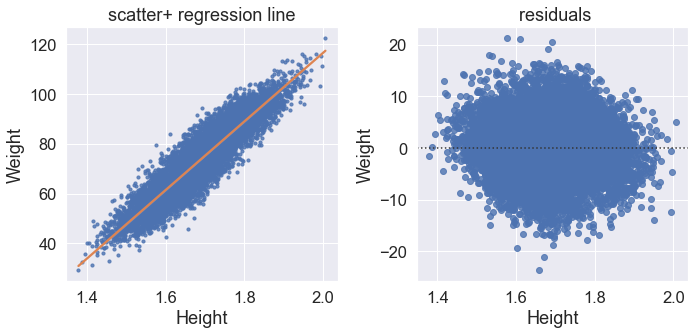

In [92]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
ax = axs[0]
ax.set_title('scatter+ regression line')
sns.regplot(
        data=data, x='Height', y='Weight',
        line_kws={"color": "C1"}, scatter_kws={"s": 10}, ax=ax)
ax = axs[1]
ax.set_title(f' residuals')
sns.residplot(
data=data, x='Height', y='Weight',
ax=ax)
fig.tight_layout()

## Cook's distance


In [93]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# fit the regression model using statsmodels library
f = 'Weight ~ Height'
model = ols(formula=f, data=data).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

### Outlier ratio

At threshold 4/N = 0.00040, 365 samples are considered outliers (3.65% of the samples)


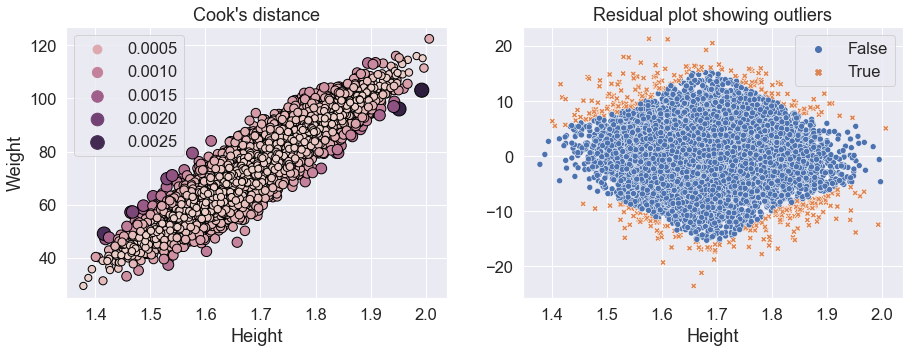

In [94]:
# TODO complete to show the outlier count and ratio
threshold = 4/data.shape[0]
is_outlier = distance > threshold
print(f'At threshold 4/N = {threshold:0.5f}, '
      f'{is_outlier.sum()} samples are considered outliers '
      f'({is_outlier.mean()*100:0.2f}% of the samples)')

# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Cook\'s distance')
sns.scatterplot(data=data, x="Height", y="Weight",
                hue=distance, size=distance, ax=axs[0],
                sizes=(50, 200), edgecolor='black', linewidth=1)


axs[1].set_title('Residual plot showing outliers')
sns.scatterplot(data=data, x="Height", y=model.resid, ax=axs[1],
                style=is_outlier, hue=is_outlier)
plt.show()
